# Airbnb Analysis - Munich Housing 

In [1]:
# Import dependencies

import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
from scipy.stats import pearsonr
from datetime import datetime
from scipy.stats import ttest_ind
from collections import Counter, defaultdict
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

In [2]:
# Reading datasets
calendarjun23 = pd.read_csv('calendar_jun23.csv', delimiter=',') #Jun23 - Jun24
calendarmar23 = pd.read_csv('calendar_mar23.csv', delimiter=',') #Mar23 - Jan24
calendardec22 = pd.read_csv('calendar_dec22.csv', delimiter=',') #Dec22 - Oct23
calendarsep22 = pd.read_csv('calendar_sep22.csv', delimiter=',') #Sep22 - Jun23
listingsjun23 = pd.read_csv('listings.csv', delimiter=',')

## Exploring dataset

In [3]:
# Allow .head() to show all column names

pd.set_option('display.max_columns', None) 
listingsjun23.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,97945,Rental unit in Munich · ★4.84 · 1 bedroom · 1 ...,517685,Angelika,NaN,Hadern,48.11492,11.48954,Entire home/apt,80,2,129,2019-10-03,0.90,2,173,0,NaN
1,114695,Rental unit in Munich · ★4.78 · 1 bedroom · 3 ...,581737,Stephan,NaN,Berg am Laim,48.12071,11.63758,Entire home/apt,100,2,56,2023-05-26,0.38,2,103,2,NaN
2,127383,Rental unit in Munich · ★4.85 · 1 bedroom · 1 ...,630556,Sonja,NaN,Maxvorstadt,48.15199,11.56482,Entire home/apt,120,3,107,2022-06-14,0.73,1,2,0,NaN
3,159634,Rental unit in Munich · ★4.62 · 1 bedroom · 1 ...,765694,Susana,NaN,Pasing-Obermenzing,48.13855,11.46586,Entire home/apt,60,2,38,2022-12-15,0.26,1,1,4,NaN
4,170154,Home in Munich · ★4.95 · 2 bedrooms · 2 beds ·...,108297,Alex,NaN,Sendling-Westpark,48.10814,11.52733,Private room,70,3,532,2023-06-20,3.72,1,165,22,NaN


In [4]:
calendarjun23.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,97945,2023-06-27,f,$80.00,$80.00,2,90
1,97945,2023-06-28,f,$80.00,$80.00,2,90
2,97945,2023-06-29,f,$80.00,$80.00,2,90
3,97945,2023-06-30,f,$80.00,$80.00,2,90
4,97945,2023-07-01,f,$80.00,$80.00,2,90


## Data Analysis

### Exploring Munich Housing prices throughout the year

In [5]:
# Define function to clean price column of dataset (remove $)

def clean(df, to_be_cleaned, string_remov):
    '''
    INPUT: df = dataframe, to_be_cleaned = name of column that needs to be cleaned, string_remov = string in column that should be replaced
    OUTPUT: changed dataframe
    '''
    # cleaning price column
    conv_str = lambda x: str(x)[1:].replace(',', '') if string_remov in str(x) else x
    df[to_be_cleaned] = df[to_be_cleaned].apply(conv_str)
    df[to_be_cleaned] = df[to_be_cleaned].apply(lambda x: float(x))
    
    return df

In [6]:
# Define function to format columns in df for plot function

def format_plot(df):
    '''
    INPUT: dataframe
    OUTPUT: Series with average price throughout time; Series with dates in np.datetime64 format
    '''
    # average price throughout time
    grouped_date = df.groupby('date')['price'].mean()
    
    # remove year from date column to allow to lay each calendar dataframe price column on top of each other
    index_date = [x[5:] for x in grouped_date.index]

    return index_date, grouped_date

In [7]:
# # get the descriptive statistics of average price per listing
# clean_calendarjun23 = clean(calendarjun23, 'price', '$')
# grouped_price = clean_calendarjun23.groupby('listing_id')['price'].mean()

# grouped_price.describe()

In [8]:
# clean all calendar price columns

Xjun23, yjun23 = format_plot(clean(calendarjun23, 'price', '$'))
Xmar23, ymar23 = format_plot(clean(calendarmar23, 'price', '$'))
Xdec22, ydec22 = format_plot(clean(calendardec22, 'price', '$'))
Xsep22, ysep22 = format_plot(clean(calendarsep22, 'price', '$'))

In [9]:
# format date column to datetime format, removing the year to later allow for overlapping plotting based on day and month
Xjun23 = [datetime.strptime('2000-' + x, '%Y-%m-%d') for x in Xjun23]
Xmar23 = [datetime.strptime('2000-' + x, '%Y-%m-%d') for x in Xmar23]
Xdec22 = [datetime.strptime('2000-' + x, '%Y-%m-%d') for x in Xdec22]
Xsep22 = [datetime.strptime('2000-' + x, '%Y-%m-%d') for x in Xsep22]

In [10]:
# # plot the average prices across all listings (Jun23-Jun24)

# plt.figure(figsize=(15,6))
# plt.hist(grouped_price, bins=1000);
# plt.xlim(0, 3000)

In [11]:
# average price throughout time
grouped_date = calendarjun23.groupby('date')['price'].mean()

grouped_date.describe()

count    365.000000
mean     195.662366
std       16.355281
min      170.559274
25%      190.237097
50%      192.200282
75%      197.299630
max      271.400564
Name: price, dtype: float64

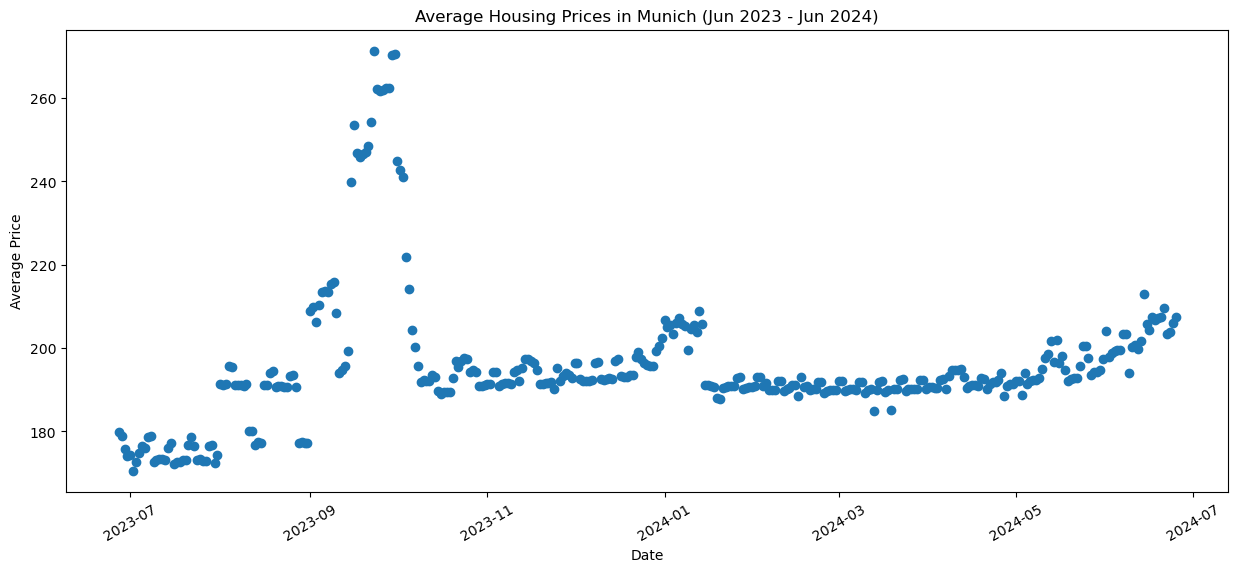

In [12]:
# plot the average prices across all Jun23-Jun24

index_date = [np.datetime64(x) for x in grouped_date.index]

fig, ax = plt.subplots(figsize=(15,6))

plt.scatter(index_date, grouped_date.values)
plt.xlabel('Date')
plt.ylabel('Average Price')
#ax.set_ylim([100,500])
plt.title('Average Housing Prices in Munich (Jun 2023 - Jun 2024)')
plt.xticks(rotation=30);

In [13]:
# plotting the price data of relevant calendar dataframes
def plot_cal(x_lst, y_lst, year_lst, color_lst):
    '''
    This function returns a scatterplot with average price data from multiple years layed ontop of each other
    INPUT: index_date is x_lst, grouped_date is y_lst
    OUTPUT: scatterplot of all average prices of calendar dataframes over time
    '''
    # plot data
    fig, ax = plt.subplots(figsize=(15,6))
    
    for i in range(len(x_lst)):
        ax.scatter(x_lst[i], y_lst[i].values, c=color_lst[i], label=year_lst[i])
    
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    ax.set_ylim([100,500])
    monthyearFmt = mdates.DateFormatter('%B') #Creates a date formatter to display the month's full name on the x-axis.
    ax.xaxis.set_major_formatter(monthyearFmt)#Applies the date formatter to the x-axis.
    plt.legend(loc='upper left')
    plt.title('Average prices throughout the year');
    #plt.xticks(rotation=30);

In [14]:
# creating input lists for plot function
x_lst = [Xjun23, Xmar23, Xdec22, Xsep22]
y_lst = [yjun23, ymar23, ydec22, ysep22]
year_lst = ['06/2023 until 06/2024','03/2023 until 01/2024','12/2022 until 10/2023', '09/2022 until 06/2023']
color_lst = ['b', 'r', 'g', 'y', 'm']

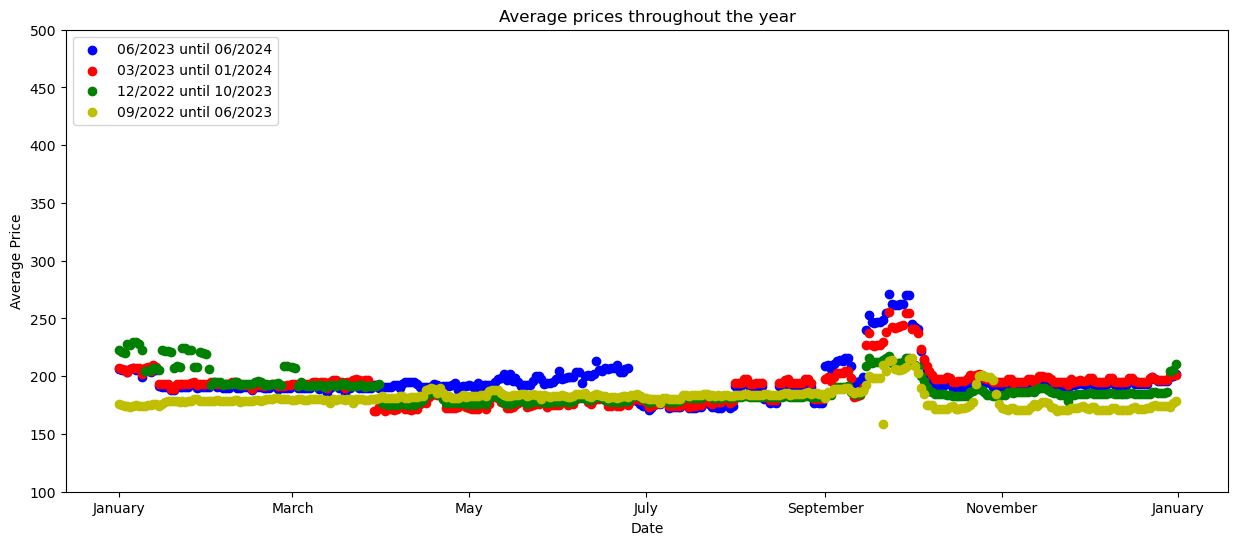

In [15]:
# plotting all three calendars' average prices
plot_cal(x_lst, y_lst, year_lst, color_lst)

In [16]:
# check how many of the properties had adjusted prices throughout the year
std_price = calendarjun23.groupby('listing_id')['price'].std()

print(list(std_price.values).count(0.0)) #std = 0 implies constant price
print(std_price.shape[0])# Total number of listings

2157
5677


This means that 2157 (out of 5677) properties do not fluctuate in price. The remaining 3520 properties do.



### Evaluation

Prices spikes occur in mid Sep - Oct period. This is likely explained by Oktoberfest taking place in October. Otherwise, housing prices remain quite stable hovering at the $200 price range.

## Understanding the neighborhoods

In [17]:
listingsjun23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5677 entries, 0 to 5676
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              5677 non-null   int64  
 1   name                            5677 non-null   object 
 2   host_id                         5677 non-null   int64  
 3   host_name                       5677 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   5677 non-null   object 
 6   latitude                        5677 non-null   float64
 7   longitude                       5677 non-null   float64
 8   room_type                       5677 non-null   object 
 9   price                           5677 non-null   int64  
 10  minimum_nights                  5677 non-null   int64  
 11  number_of_reviews               5677 non-null   int64  
 12  last_review                     45

In [18]:
# create separate dataframe with information of distances from center per neighborhood
munich_long = 11.575382 #Lat and long of marienplatz square
munich_lat = 48.137107

avg_diff_long = listingsjun23.groupby('neighbourhood')['longitude'].mean()
avg_diff_lat = listingsjun23.groupby('neighbourhood')['latitude'].mean()

diff_long_df = pd.DataFrame(avg_diff_long)
diff_lat_df = pd.DataFrame(avg_diff_lat)
diff_long_df['neighborhood'] = diff_long_df.index
diff_lat_df['neighborhood'] = diff_lat_df.index
diff_long_df = diff_long_df.reset_index(drop=True)
diff_lat_df = diff_lat_df.reset_index(drop=True)

diff_pos_df = pd.merge(diff_long_df, diff_lat_df, on='neighborhood', how='outer')
diff_pos_df = diff_pos_df[['neighborhood', 'latitude', 'longitude']]

diff_pos_df = diff_pos_df.append({'neighborhood': 'Center', 'latitude': munich_lat, 'longitude': munich_long}, ignore_index=True)

diff_pos_df

/var/folders/f7/t51lvbwn6_xg2vbn66mndyq40000gn/T/ipykernel_56163/1383231596.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff_pos_df = diff_pos_df.append({'neighborhood': 'Center', 'latitude': munich_lat, 'longitude': munich_long}, ignore_index=True)


,neighborhood,latitude,longitude
0,Allach-Untermenzing,48.185759,11.464133
1,Altstadt-Lehel,48.136953,11.579486
2,Au-Haidhausen,48.128248,11.592950
3,Aubing-Lochhausen-Langwied,48.146217,11.415828
4,Berg am Laim,48.125944,11.631335
5,Bogenhausen,48.152313,11.627631
6,Feldmoching-Hasenbergl,48.206323,11.540729
7,Hadern,48.119174,11.484802
8,Laim,48.137052,11.507380
9,Ludwigsvorstadt-Isarvorstadt,48.130994,11.562808


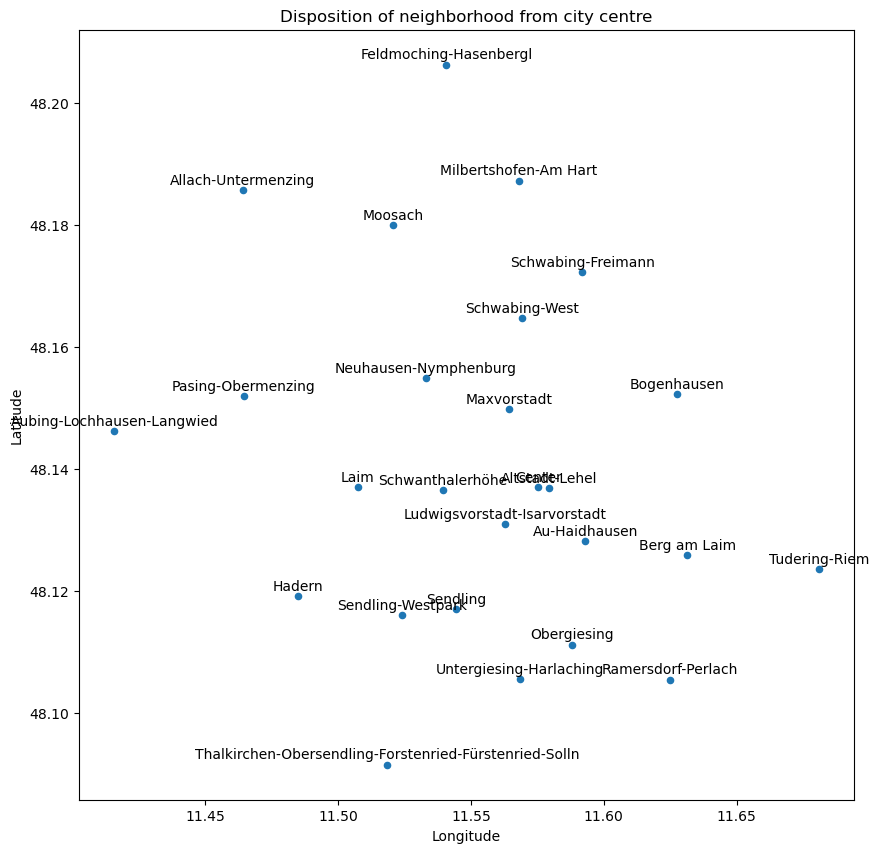

In [19]:
# plotting the distance of each neighborhood from the center
fig, ax = plt.subplots(figsize=(10,10))

def plot_neighbor(x_val, y_val, text, title, marker_size=20):
    '''
    plotting scatterplot showing distance, vibe and average price (if relevant) of neighborhoods
    INPUT: x_val = x values in list format, y_val = y values in list format, text = text for annotation of points,
    title = title of the plot, marker_size = size of the data points
    OUTPUT: scatterplot
    '''
    plt.scatter(x_val, y_val, s=marker_size)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)

    for i, neigh in enumerate(text):
        ax.annotate(neigh, xy=(x_val[i], y_val[i]), xytext=(0, 6), textcoords='offset pixels', ha='center');

plot_neighbor(diff_pos_df['longitude'], diff_pos_df['latitude'], diff_pos_df['neighborhood'], "Disposition of neighborhood from city centre")

Will be more useful to compare price of neighbohood with respect to distance from city centre

In [20]:
# average price per neighborhood
neighborhood_price = pd.DataFrame(listingsjun23.groupby('neighbourhood')['price'].mean())

neighborhood_price['neighborhood'] = neighborhood_price.index
neighborhood_price = neighborhood_price.reset_index(drop=True)
neighborhood_price.sort_values('price', inplace=True)

neighborhood_price.head()

,price,neighborhood
11,102.185185,Milbertshofen-Am Hart
3,104.787671,Aubing-Lochhausen-Langwied
7,111.892308,Hadern
12,114.140187,Moosach
15,115.026316,Pasing-Obermenzing


In [21]:
price_pos_df = pd.merge(diff_pos_df, neighborhood_price, on='neighborhood', how='outer')
price_pos_df.head()

,neighborhood,latitude,longitude,price
0,Allach-Untermenzing,48.185759,11.464133,119.983051
1,Altstadt-Lehel,48.136953,11.579486,228.757576
2,Au-Haidhausen,48.128248,11.592950,402.432000
3,Aubing-Lochhausen-Langwied,48.146217,11.415828,104.787671
4,Berg am Laim,48.125944,11.631335,190.940678


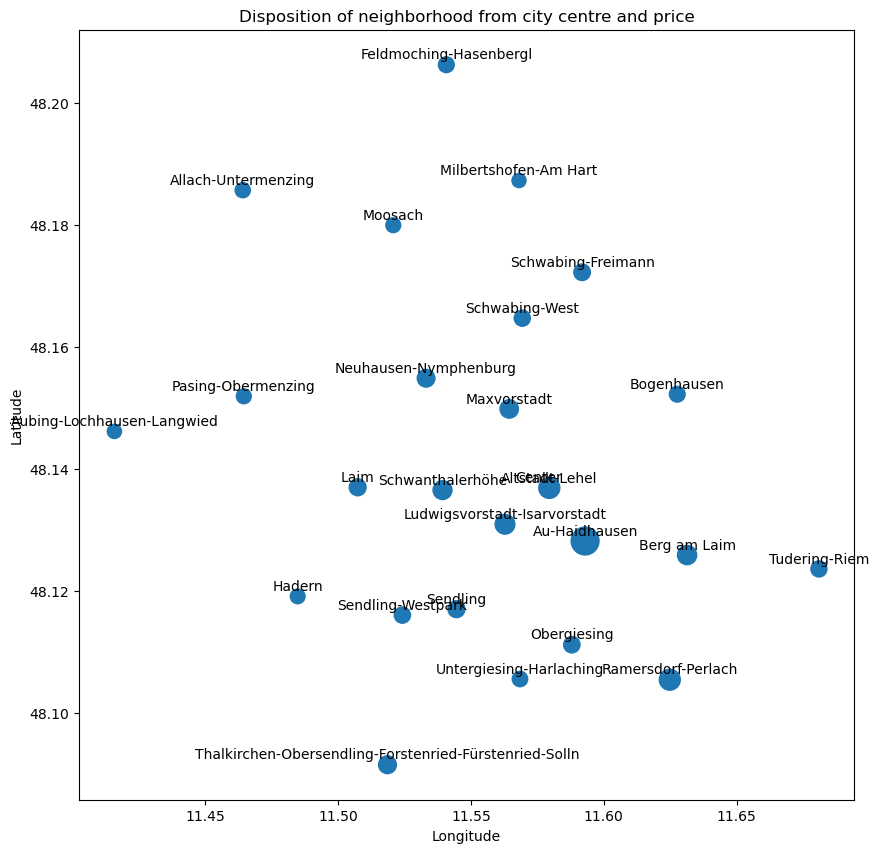

In [22]:
# plotting the distance of each neighborhood from the center. 
# Size of plots corresponding average price of that neighbohood

fig, ax = plt.subplots(figsize=(10,10))

title = 'Disposition of neighborhood from city centre and price'
plot_neighbor(price_pos_df['longitude'], price_pos_df['latitude'], price_pos_df['neighborhood'], title, marker_size=price_pos_df['price']);

The above graph does not show clearly the price differences between neighborhoods. A graph would be clearer in showing the exact average prices per neighborhood, and show which neighborhood prices are above and which are below average.

In [23]:
# adding column with normalized prices
normalization = lambda x: (x - np.mean(neighborhood_price['price']))/np.std(neighborhood_price['price'])
neighborhood_price['normalize'] = neighborhood_price['price'].apply(normalization)
neighborhood_price = neighborhood_price.reset_index(drop=True)
neighborhood_price['colors'] = ['red' if val > 0 else 'green' for val in neighborhood_price['normalize'] ]

/var/folders/f7/t51lvbwn6_xg2vbn66mndyq40000gn/T/ipykernel_56163/3718929162.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)


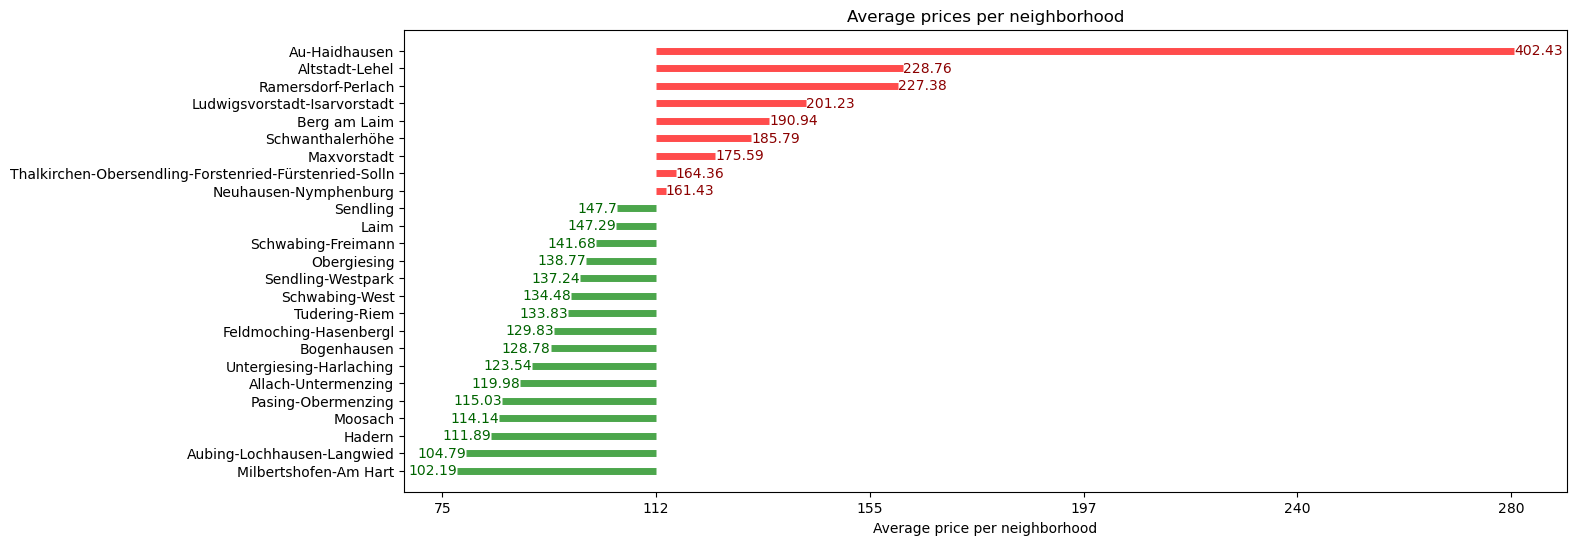

In [24]:
#Plot prices

fig, ax = plt.subplots(figsize=(15,6))
plt.hlines(y=neighborhood_price['neighborhood'], xmin=0, xmax=neighborhood_price['normalize'], color=neighborhood_price['colors'], alpha=0.7, linewidth=5);

ann_text = neighborhood_price['price']
for norm, neigh, price in zip(neighborhood_price['normalize'], neighborhood_price['neighborhood'], ann_text):
    text = plt.text(norm, neigh, round(price, 2), horizontalalignment='right' if norm < 0 else 'left', verticalalignment='center', fontdict={'color':'darkred' if norm > 0 else 'darkgreen'})

label = ['0', '75', '112', '155', '197', '240', '280', '325']
ax.set_xticklabels(label)
plt.xlabel('Average price per neighborhood')
plt.title('Average prices per neighborhood');

## Differences between single hosts and multi-hosts

In [25]:
# create new data frame with listings only containing listings that are the only listing of a host in Boston

host_1 = listingsjun23[listingsjun23['calculated_host_listings_count'] == 1]
host_more = listingsjun23[listingsjun23['calculated_host_listings_count'] > 1]

In [26]:
# average prices
mean_1 = host_1['price'].mean()
mean_more = host_more['price'].mean()

print('single-listing', mean_1)
print('multi-listing', mean_more)

single-listing 169.01981981981982
multi-listing 187.56529017857142


Generally more expensive to stay at a multi-listing property. (However, this data is not adjusted for room size, amenities or location.)



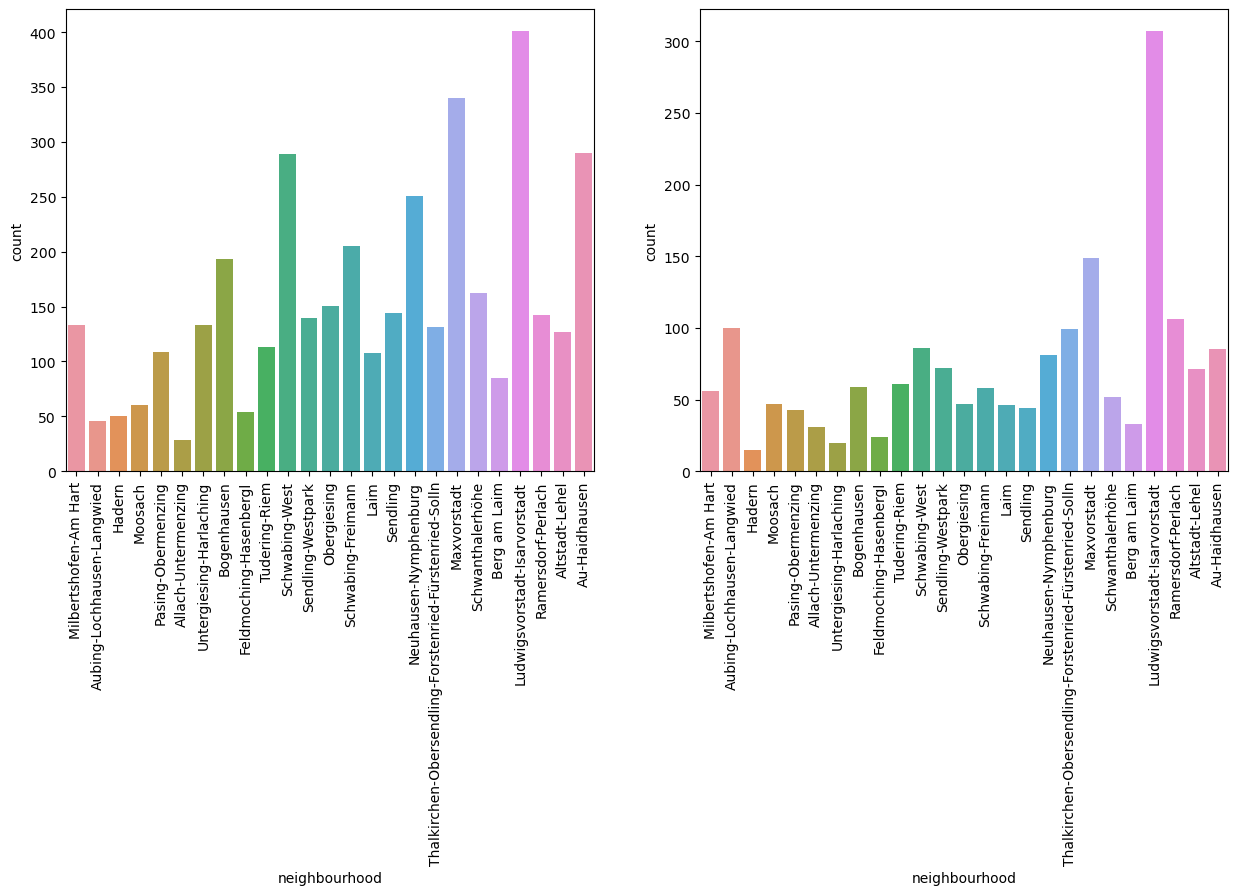

In [27]:
# plotting number of properties per neighborhood split by single- and multi-listings
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(x=host_1['neighbourhood'], order=neighborhood_price['neighborhood'])
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.countplot(x=host_more['neighbourhood'], order=neighborhood_price['neighborhood'])
plt.xticks(rotation=90);

In [28]:
# Lists identifying above and below average price neighborhoods
below_avg = [x for x, y in zip(neighborhood_price['neighborhood'], neighborhood_price['normalize']) if y < 0]
above_avg = [x for x, y in zip(neighborhood_price['neighborhood'], neighborhood_price['normalize']) if y > 0]
below_avg

['Milbertshofen-Am Hart',
 'Aubing-Lochhausen-Langwied',
 'Hadern',
 'Moosach',
 'Pasing-Obermenzing',
 'Allach-Untermenzing',
 'Untergiesing-Harlaching',
 'Bogenhausen',
 'Feldmoching-Hasenbergl',
 'Tudering-Riem',
 'Schwabing-West',
 'Sendling-Westpark',
 'Obergiesing',
 'Schwabing-Freimann',
 'Laim',
 'Sendling']

In [29]:
# get ratio of below average and above average neighborhoods
# Creating temporary dataframes for further analysis on property ratio in above and below average neighborhoods

def temp_df(df):
    '''
    INPUT: df = data frame containing properties with either host who only has one listing or
           data frame containing properties with host who has more than one listing on Airbnb
    OUTPUT: dataframe 
    '''
    temp_df = pd.DataFrame(df.groupby('neighbourhood')['name'].count())
    temp_df = temp_df.reset_index()
    return temp_df


# Calculating number of properties within above or below average neighborhoods

def avg_ratio(df, abv_blw):
    '''
    INPUT: df = dataframe with count of properties per neighborhood, abv_blw = list of above or below average neighborhoods
    OUTPUT: count of properties
    '''
    count = 0
    for x in abv_blw:
        for row in df['neighbourhood']:
            if neigh == row:
                loc_row = df[df['neighbourhood']== x].index.item()
                count += df['name'][loc_row]
    return count

In [30]:
# calculating the ratios
temp_1_df = temp_df(host_1)
temp_more_df = temp_df(host_more)

below_host_1 = avg_ratio(temp_1_df, below_avg)
above_host_1 = avg_ratio(temp_1_df, above_avg)
host_1_ratio = below_host_1/(below_host_1+above_host_1)

below_host_more = avg_ratio(temp_more_df, below_avg)
above_host_more =  avg_ratio(temp_more_df, above_avg)
host_more_ratio =  below_host_more/(below_host_more + above_host_more) 

print('single-listing', host_1_ratio)
print('multi-listing', host_more_ratio)

single-listing 0.5034749034749034
multi-listing 0.45145089285714285


## Evaluation
We can see that the single-listing properties are more often in below-average priced neighborhoods, while multi-listing properties are in areas with higher average prices